# YOLOv8 Model Training & OCR Integration with Tesseract

This notebook
1. loads the dataset configuration and trains a YOLOv8 model for license plate detection.
2. demonstrates how to load the trained YOLOv8 model, detect a license plate in an image, crop that region, and apply Tesseract OCR to extract the text.


In [12]:
import os
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [1]:
!pip install pytesseract
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
import os, shutil
from ultralytics import YOLO
import yaml
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Copy Kaggle data to a flat 'temp' folder

In [3]:
os.makedirs('kaggle_temp', exist_ok=True)
for root,_,files in os.walk('/content/drive/MyDrive/project455/data/kaggle'):
    for f in files:
        src = os.path.join(root,f)
        dst = os.path.join('kaggle_temp', f)
        shutil.copy(src, dst)

Separate images vs labels

In [4]:
ipaths, tpaths = [], []
for f in sorted(os.listdir('kaggle_temp')):
    if f.lower().endswith(('.jpg','jpeg','png')):
        ipaths.append(os.path.join('kaggle_temp',f))
    elif f.endswith('.txt'):
        tpaths.append(os.path.join('kaggle_temp',f))
print(len(ipaths), "images,", len(tpaths), "labels")

2083 images, 2021 labels


Split into train/valid/test

In [ ]:
BASE_DIR    = '/content/drive/MyDrive/project455'
IMAGES_DIR  = os.path.join(BASE_DIR, 'data', 'kaggle', 'images')
LABELS_DIR  = os.path.join(BASE_DIR, 'data', 'kaggle', 'labels')
OUTPUT_DIR  = os.path.join(BASE_DIR, 'datasets')

# Make train/valid/test dirs
for split in ('train','valid','test'):
    os.makedirs(os.path.join(OUTPUT_DIR, split), exist_ok=True)

# Gather all label stems
label_files = [f for f in os.listdir(LABELS_DIR) if f.lower().endswith('.txt')]
stems       = sorted(os.path.splitext(f)[0] for f in label_files)
print(f"Found {len(stems)} labeled plates")

# Pair each stem with its actual image path
pairs = []
for stem in stems:
    for ext in ('.png','.jpg','.jpeg'):
        img_path = os.path.join(IMAGES_DIR, stem + ext)
        if os.path.exists(img_path):
            lbl_path = os.path.join(LABELS_DIR, stem + '.txt')
            pairs.append((img_path, lbl_path))
            break
    else:
        print(f"⚠️  label {stem}.txt has no matching image—skipping")

print(f"Using {len(pairs)} image+label pairs for training")

# Round‐robin split into train/valid/test
for i, (img_path, lbl_path) in enumerate(pairs):
    phase = ('train','valid','test')[i % 3]
    dst_img = os.path.join(OUTPUT_DIR, phase, os.path.basename(img_path))
    dst_lbl = os.path.join(OUTPUT_DIR, phase, os.path.basename(lbl_path))
    shutil.copy(img_path, dst_img)
    shutil.copy(lbl_path, dst_lbl)

print("✅ Done splitting into train/valid/test")

 Create plate.yaml

In [6]:
yaml_dict = {
    'train': '/content/drive/MyDrive/project455/datasets/train',
    'val':   '/content/drive/MyDrive/project455/datasets/valid',
    'test':  '/content/drive/MyDrive/project455/datasets/test',
    'nc':    1,
    'names': ['plate']
}
with open('/content/drive/MyDrive/project455/data/plate.yaml','w') as f:
    yaml.dump(yaml_dict, f, default_flow_style=True)

Train YOLOv8

In [7]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

results = model.train(
    data='/content/drive/MyDrive/project455/data/plate.yaml',
    epochs=10,
    imgsz=416,
    batch=32,
    amp=True,
    freeze=10,
    workers=4,
    name='quick_plate_run'
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 156MB/s]


Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/project455/data/plate.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=quick_plate_run, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 40.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mode

100%|██████████| 5.35M/5.35M [00:00<00:00, 138MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.1±0.2 MB/s, size: 68.4 KB)


train: Scanning /content/drive/MyDrive/project455/datasets/train... 673 images, 1 backgrounds, 1 corrupt: 100%|██████████| 674/674 [00:28<00:00, 23.33it/s] 

train: /content/drive/MyDrive/project455/datasets/train/License (714).png: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/project455/datasets/train/License (714).png'


train: New cache created: /content/drive/MyDrive/project455/datasets/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.2±1.3 ms, read: 0.0±0.0 MB/s, size: 19.9 KB)


val: Scanning /content/drive/MyDrive/project455/datasets/valid.cache... 674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 674/674 [00:00<?, ?it/s]


Plotting labels to runs/detect/quick_plate_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/quick_plate_run
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.863G     0.8681      1.617      1.088          1        416: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]

                   all        674        715      0.964      0.927      0.961       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.15G     0.7664      0.893      1.025          1        416: 100%|██████████| 22/22 [00:08<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]

                   all        674        715      0.889      0.913      0.928      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.15G     0.7443     0.7557      1.011          1        416: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]

                   all        674        715       0.98      0.965      0.974      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.16G     0.6747     0.6597     0.9885          1        416: 100%|██████████| 22/22 [00:05<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        674        715      0.985      0.965      0.982      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.16G     0.6782     0.5984     0.9831          1        416: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

                   all        674        715      0.981      0.963      0.984      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.16G     0.6696     0.5509     0.9856          1        416: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

                   all        674        715      0.989       0.97      0.985      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.16G     0.6367      0.507     0.9575          1        416: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]

                   all        674        715      0.989      0.965      0.983       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.16G     0.6205     0.4801     0.9563          1        416: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

                   all        674        715      0.987       0.97      0.985      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.16G     0.5935     0.4444     0.9495          1        416: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.59it/s]

                   all        674        715      0.985      0.975       0.99      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.16G     0.6157     0.4189     0.9723          1        416: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

                   all        674        715      0.991      0.969      0.989      0.808



10 epochs completed in 0.037 hours.
Optimizer stripped from runs/detect/quick_plate_run/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/quick_plate_run/weights/best.pt, 6.2MB

Validating runs/detect/quick_plate_run/weights/best.pt...
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


                   all        674        715      0.991      0.969      0.989      0.808
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/quick_plate_run


Save final weights

In [8]:
model.val()  # show metrics
model.save('/content/drive/MyDrive/project455/model/yolov8_license_plate_model.pt')

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 10.8±4.4 MB/s, size: 20.4 KB)


val: Scanning /content/drive/MyDrive/project455/datasets/valid.cache... 674 images, 0 backgrounds, 0 corrupt: 100%|██████████| 674/674 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:14<00:00,  1.56it/s]


                   all        674        715      0.994       0.97       0.99      0.811
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/quick_plate_run2


Run YOLOv8 to localize the plate(s)

Crop to each plate region

Then run OCR only on those small crops

1. Load the model

In [9]:
model = YOLO('/content/yolov8n.pt')

2. Define helper

In [13]:
def detect_and_ocr(img_path):
    img = cv2.imread(img_path)
    res = model.predict(img_path)[0]
    if not res.boxes:
        return None, None
    x1,y1,x2,y2 = map(int, res.boxes.xyxy[0].cpu().numpy())
    crop = img[y1:y2, x1:x2]
    text = pytesseract.image_to_string(crop, config='--psm 7')
    return crop, text.strip()

3. Test on Kaggle samples -  OCR on the cropped license-plate regions that YOLO finds

00000002.jpg → Plate #1: KAQ4

565



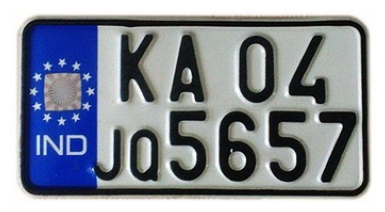

00000002.jpg → Plate #2: KA04JO5657



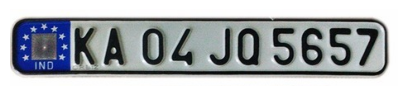

00000073.jpg → Plate #1: EE SN
34 PV BN
PDE

LROPP



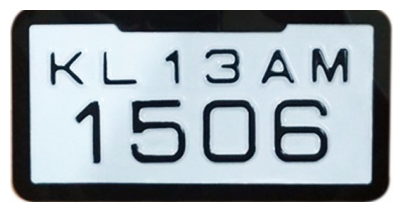

00000073.jpg → Plate #2: KL1SAM1S506



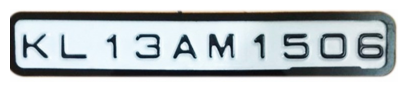

License (1207).png → Plate #1: MH02BP2897



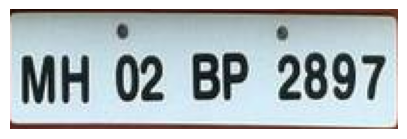

In [30]:
def ocr_variants(crop):
    variants = []
    # raw
    variants.append((crop, '--psm 11'))
    # grayscale + OTSU
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    variants.append((th, '--psm 7'))
    # adaptive threshold
    adapt = cv2.adaptiveThreshold(
        gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,11,2
    )
    variants.append((adapt, '--psm 6'))

    best = ""
    for img, cfg in variants:
        # whitelist A–Z & 0–9 only
        cfg_full = f"{cfg} --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        txt = pytesseract.image_to_string(img, config=cfg_full).strip()
        # keep the longest non-empty string
        if len(txt) > len(best):
            best = txt
    return best

def detect_and_ocr_all(img_path, conf=0.25, pad=5):
    img     = cv2.imread(img_path)
    h, w    = img.shape[:2]
    results = model.predict(img_path, conf=conf, verbose=False)[0]

    outputs = []
    for box in results.boxes.xyxy.cpu().numpy():
        x1,y1,x2,y2 = map(int, box)
        # expand box by `pad` pixels (clamped to image bounds)
        x1, y1 = max(0, x1-pad), max(0, y1-pad)
        x2, y2 = min(w, x2+pad), min(h, y2+pad)
        crop = img[y1:y2, x1:x2]
        txt  = ocr_variants(crop)
        outputs.append((crop, txt))
    return outputs

test_dir  = '/content/drive/MyDrive/project455/datasets/test'
test_imgs = sorted(f for f in os.listdir(test_dir)
                   if f.lower().endswith(('.png','.jpg','jpeg')))

for idx in [0,15,137]:
    fname  = test_imgs[idx]
    path   = os.path.join(test_dir, fname)
    plates = detect_and_ocr_all(path, conf=0.2, pad=8)

    if not plates:
        print(f"{fname} → (no plates detected)\n")
        continue

    for j,(crop, txt) in enumerate(plates, start=1):
        plt.figure(figsize=(5,2.5))
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        print(f"{fname} → Plate #{j}: {txt}\n")
        plt.show()
